# PyTorch computer vision

## 0. Computer vision libraries in Pytorch

* [torchvision] : Base domain library for PyTorch computer vision
* [torchvision.datasets] : get datasets and data loading functions for computer vision here
* [torchvision.models] : get pretrained computer vision models that you can leverage for your own problems
* [torchvision.transforms] : functions for manipulating your vision data (images) to be suitable for use with an ML model
* [torch.utils.data.Dataset]: Base dataset class for PyTorch
* [torch.utils.data.dataloader]: Creates a Python iterable over a dataset


In [2]:
# import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# check versions
print(torch.__version__)
print(torchvision.__version__)

2.4.1
0.19.1


## 1. Getting a dataset
The dataset we will be using is FashionMNIST from torchvision.datasets

In [3]:
# setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root= "data", # where to download the dataset to?
    train=True, # Do we want the training dataset?
    download= True, # do we want to download yes/no?
    transform= torchvision.transforms.ToTensor(),  # How do we want to transform the data?
    target_transform=None # How do we want to transform the labels/targets?

) 

# setup testing data
from torchvision import datasets
test_data = datasets.FashionMNIST(
    root= "data", # where to download the dataset to?
    train=False, # Do we want the training dataset?
    download= True, # do we want to download yes/no?
    transform= torchvision.transforms.ToTensor(),  # How do we want to transform the data?
    target_transform=None # How do we want to transform the labels/targets?

) 

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
# see the first training example
image,label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
print(f" Image Shape: {image.shape} -> [color_channel, height, width]" )
print(f"Image label: {class_names[label]}")


 Image Shape: torch.Size([1, 28, 28]) -> [color_channel, height, width]
Image label: Ankle boot


## 1.2 Visualize the data


Image Shape: torch.Size([1, 28, 28])


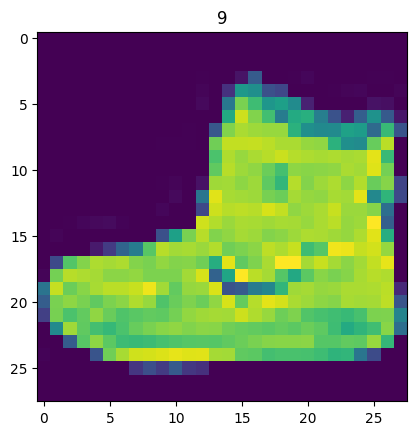

In [10]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);


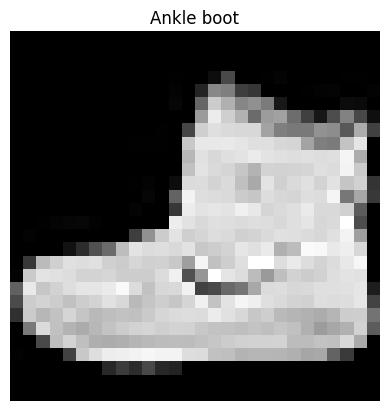

In [11]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label]);
plt.axis(False);

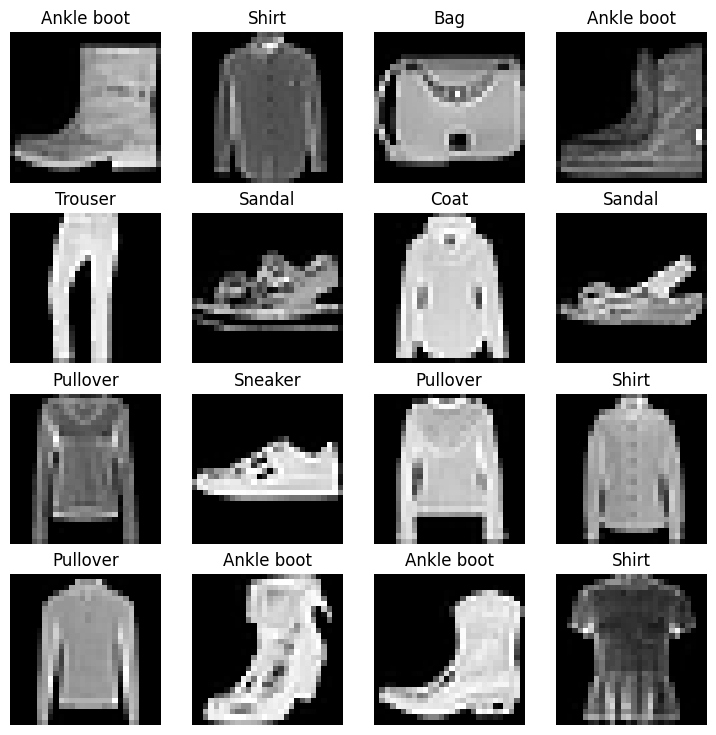

In [12]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9) )
rows, cols =4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0,len(train_data), size =[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = "gray")
    plt.title(class_names[label])
    plt.axis(False);

* Do you think these items of clothing(images) could be modelled with pure linear lines? Or do you think we will need non-linearity?


## 2. Prepare dataloader

Right now, our data is in the form of PyTorch Datasets.

Dataloader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or Mini-batches)

why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) 60000 images in one hit. so we break it down to 32 images at a time (batch size of 32)
2. It gives our neural network more chance to updates its gradients per epoch.


In [13]:
from torch.utils.data import DataLoader
# Setup the batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True)
test_dataloader = DataLoader(dataset= test_data,
                             batch_size= BATCH_SIZE,
                             shuffle= False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fc518918e20>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc518918700>)

In [14]:
# Let's check out what we have created 
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f" Length of train_dataloader : {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fc518918e20>, <torch.utils.data.dataloader.DataLoader object at 0x7fc518918700>)
 Length of train_dataloader : 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [15]:
# check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image_size: torch.Size([1, 28, 28])
 Label: 8, label size: torch.Size([])


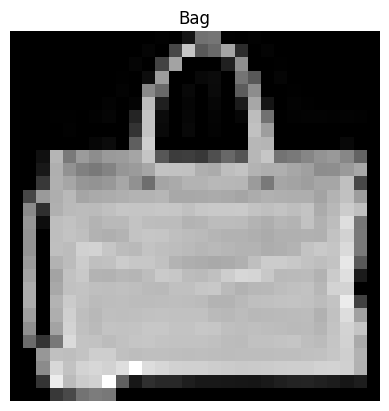

In [16]:
# show a sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch) , size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f"Image_size: {img.shape}")
print(f" Label: {label}, label size: {label.shape}")


## 3. Model_0 : Build a baseline Model

When starting to build a series of machine learning model, it's better to start with baseline model

A baseline model is a simple model you will try and improve upon with subsequent models/experiments

In other words: Start simply and add complexity when necessary


In [17]:
# create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
x.shape

# Flatten the sample
output = flatten_model(x)

# Print out what happened 
print(f" Shape before flattening: {x.shape} -> [color_channel, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channel, height*width]")

 Shape before flattening: torch.Size([1, 28, 28]) -> [color_channel, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channel, height*width]


In [18]:
output.squeeze()

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0078, 0.0078,
        0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2863, 0.0000, 0.0000, 0.0078, 

In [19]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.Linear(in_features= hidden_units, out_features= output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)


In [20]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape= 28*28, hidden_units= 20 , output_shape= len(class_names))
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [21]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)


tensor([[-0.0898,  0.4250,  0.0166, -0.2554, -0.0252, -0.2772,  0.0576,  0.1981,
         -0.0374,  0.0360]], grad_fn=<AddmmBackward0>)

In [22]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [ 0.0170, -0.0162,  0.0170,  ...,  0.0121,  0.0111, -0.0152],
                      [-0.0014,  0.0008, -0.0198,  ...,  0.0154,  0.0030, -0.0313],
                      [ 0.0080, -0.0075,  0.0190,  ...,  0.0070, -0.0008, -0.0176]])),
             ('layer_stack.1.bias',
              tensor([-0.0007,  0.0044,  0.0010,  0.0270, -0.0205,  0.0162,  0.0329, -0.0257,
                      -0.0280,  0.0121, -0.0127, -0.0008, -0.0333,  0.0218, -0.0024,  0.0022,
                      -0.0124,  0.0124, -0.0006, -0.0142])),
             ('layer_stack.2.weight',
              tensor([[ 0.0555, -0.0830,  0.0830, -0.2142, -0.0865, -0.1532,  0.0951, -0.1570,
          

### 3.1 Set up loss and optimizer and evaluation metrics

* loss function : since we are working with multi-class data, our loss function will be nn.CrossEntropyLoss()
* Optimizer: Our optimizer 'torch.optim.SGD' (Stochastic Gradient Descent)
* Evaluation Metrics: Since we're working on a classification problem, let's use accuracy as our evaluation metrics


In [23]:
import requests
from pathlib import Path
# Download helper functions from Pytorch repo

if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skipping downloading")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

    

In [24]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr =0.1)


### 3.2 Creating a function to time our experiments

machine learning is very experimental

Two of the main things you'll often want to track are:

    1. Model's performance (loss and accuracy e.t.c)
    2. How fast it runs


In [25]:
from timeit import default_timer as timer

def print_train_time(start: float, 
                     end : float,
                     device: torch.device = None):
    """ prints difference between start and end time.
    """
    total_time = end - start
    print(f"Train time on {device} : {total_time: .3f} seconds")
    return total_time



In [26]:
start_time = timer()
# some code ...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu :  0.000 seconds


3.339163959026337e-05

In [27]:
# UPTOHERE: 3.3 Creating a training and testing loop and training a model on batches of data
# Highlight that the optimizer will update a model's parameter once per batch rather than once per epoch...



### 3.3 Creating a training loop and training a model on batches of data
1.  Loop through epochs
2. loop through training batches, perform training steps, calculate the train loss 
*per_batch*
3. Loop through testing batches, perform testing steps, calculate the test loss 
*per_batch*
4. Print out what's happening
5. Time it all (for fun)


In [28]:
# Import tqdm for progeress bar
from tqdm.auto import tqdm

# set the manual seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# set the number of epochs (we'll keep this small for faster training time)
epochs =3

# create training and test loop 
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")

    ### Training 
    train_loss = 0
    ## Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()

        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate training loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # prints out what's happening
        if batch%400 == 0 :
            print(f"looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")
        
    # Divide the train_loss by length of train_dataloader
    train_loss = train_loss/len(train_dataloader)
    

    ### Testing loop
    test_loss , test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            # 1. Forward pass 
            test_pred = model_0(X_test)

            # 2. Calculate the loss (accumulatively)
            loss = loss_fn(test_pred, y_test)
            test_loss+=loss

            # 3. Calculate accuracy
            test_acc+=accuracy_fn(y_true=y_test, y_pred = torch.softmax(test_pred, dim = 1).argmax(dim=1))
        
        # Calculate the test_loss average per batch
        test_loss /= len(test_dataloader)
        # Calculate the test_acc avaerage per batch
        test_acc /= len(test_dataloader)
    
    # printout what's happening
    print(f" \n Train_loss: {train_loss: .4f}, Test_loss: {test_loss:.4f} , Test_acc: {test_acc:.4f}")

# calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu, end = train_time_end_on_cpu, device= str(next(model_0.parameters()).device))

        

/home/nikhil/anaconda3/envs/NORA/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples


 33%|███▎      | 1/3 [00:09<00:18,  9.21s/it]

 
 Train_loss:  0.5824, Test_loss: 0.5039 , Test_acc: 82.2983
Epoch: 1
----
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples


 67%|██████▋   | 2/3 [00:18<00:09,  9.01s/it]

 
 Train_loss:  0.4747, Test_loss: 0.4823 , Test_acc: 83.0871
Epoch: 2
----
looked at 0 / 60000 samples
looked at 12800 / 60000 samples
looked at 25600 / 60000 samples
looked at 38400 / 60000 samples
looked at 51200 / 60000 samples


100%|██████████| 3/3 [00:26<00:00,  8.96s/it]

 
 Train_loss:  0.4542, Test_loss: 0.4772 , Test_acc: 83.4365
Train time on cpu :  26.893 seconds


### 4. Make Predictions and get Model 0 results


In [29]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """ Returns a dictionary containing the results of model predicting on data_loader"""
    loss, acc =0,0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions 
            y_pred = model_0(X)
            
            # Accumulate the loss and acc values per batch
            loss+= loss_fn(y_pred, y)
            acc+= accuracy_fn(y_true= y,
                              y_pred= torch.softmax(y_pred, dim =1).argmax(dim=1))
        
        # Scale the loss and acc to find the average loss/acc per batch
        loss/=len(data_loader)
        acc/=len(data_loader)
    return {"model_name":model.__class__.__name__, # onlt works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model_0 results on test dataset
model_0_results = eval_model(model= model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

100%|██████████| 313/313 [00:01<00:00, 301.65it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

### 5. Setup device agnostic code (for using a GPU if there is one)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 6. Model_1: Building a better model with non-linearity

* we learned about the power of non-linearity in notebook-02

In [31]:
from torch import nn
class FashionMNISTModelV1(nn.Module):
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_shape, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_shape),
            nn.ReLU()
        )
    
    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)


In [32]:
# Create an instance of model_1
torch.manual_seed(42)

model_1 = FashionMNISTModelV1(input_shape= 784,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

In [33]:
next(model_1.parameters()).device

device(type='cpu')

### 6.1  Creating a loss function and optimizer and evaluation metrics for model_1

In [34]:
from helper_functions import accuracy_fn
loss_fn =  nn.CrossEntropyLoss()  # measure how wrong our model is 
optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)


### 6.2 Functionizing training and evaluating/testing loops

let's create a function for 
* training loop - 'train_step()'
* testing loop - 'test_step()'


In [35]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn, 
                device: torch.device = device):
    """ performs a training with model trying to learn on data loader."""
    train_loss, train_acc = 0, 0
    # Put the model into training mode
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)

        #1. Forward pass (outputs the raw logits from the model)
        y_pred = model(X)

        # 2. calculate loss per batch
        loss =loss_fn(y_pred , y)
        train_loss+=loss
        train_acc+=accuracy_fn(y_true= y,
                                y_pred = torch.softmax(y_pred, dim=1).argmax(dim=1))

        #3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backward (backpropogation)
        loss.backward()

        # 5. optimizer step (Performs Gradient descent, updates all the weights)
        optimizer.step() 
    
        # Print out what's happening
        # if batch % 400 ==0:
        #     print(f"Looked at {batch* len(X)} / {len(train_dataloader.dataset)} samples")
        
    # Divide the train loss and acc by the length of train_dataloader
    train_loss/=len(data_loader)
    train_acc/=len(data_loader)
    print(f"Train Loss: {train_loss:.5f} | Train Acc {train_acc:.5f}")        
        

In [36]:
def test_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """ Performs a testing loop on model going over data_loader"""
    test_loss, test_acc = 0,0

    #Put the model in evaluation model
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate the loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc+= accuracy_fn(y_true = y,
                                   y_pred = torch.softmax(test_pred, dim=1).argmax(dim=1))
            
        # Divide the test loss and acc by length of test data_laoder
        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
        print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}")



In [37]:
torch.manual_seed(42)
# measure time
from timeit import default_timer as timer 
train_time_start_on_gpu = timer()

# set Epochs
epochs = 3

# create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n ....")
    train_step(model= model_1,
                data_loader = train_dataloader,
                loss_fn = loss_fn,
                optimizer=optimizer,
                accuracy_fn = accuracy_fn,
                device=device)
    
    test_step(model = model_1,
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn =accuracy_fn,
              device = device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
 ....
Train Loss: 1.09199 | Train Acc 61.34333


 33%|███▎      | 1/3 [00:09<00:18,  9.27s/it]

Test Loss: 0.95636 | Test Acc: 64.99601
Epoch: 1
 ....
Train Loss: 0.78101 | Train Acc 71.92833


 67%|██████▋   | 2/3 [00:18<00:09,  9.18s/it]

Test Loss: 0.72227 | Test Acc: 73.91174
Epoch: 2
 ....
Train Loss: 0.67027 | Train Acc 75.93667


100%|██████████| 3/3 [00:27<00:00,  9.18s/it]

Test Loss: 0.68500 | Test Acc: 75.01997
Train time on cpu :  27.529 seconds


In [38]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

*Note:* sometimes , depending on your data/ hardware you might find that your model trains faster on CPU than GPU
why is this 

    1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offered by the GPU
    2. The hardware you're using has a better CPU in terms compute capability than the GPU



In [39]:
total_train_time_model_0

26.89336382597685

In [40]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_1_results

100%|██████████| 313/313 [00:01<00:00, 291.78it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

### Model 2 Building a CNN
CNN's are known as ConvNets
CNN's are known for their capabilities to find patterns in visual data

In [41]:
# create a Convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """" Model architecture that replicates the TinyVGG model from CNN explainer website"""
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        # Create a conv layer
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= input_shape, out_channels= hidden_units, kernel_size =3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units, kernel_size =3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= hidden_units, out_channels= hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= hidden_units * 49, # there is a trick to calculate this
             out_features=output_shape)
        ) 
    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [42]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units= 10, output_shape=len(class_names)).to(device)

### 7.1 Stepping through nn.Conv2d()

In [43]:
torch.manual_seed(42)

# create a batch of images

images = torch.randn(size=(32,3,64,64))
test_image = images[0]
print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [44]:
# Create a single conv 2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)

# pass the data through the convolution layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

### 7.2 Stepping through MAX pooling layer

In [45]:
# Pass the data through the max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)
test_image_after_maxpool = max_pool_layer(conv_output)
test_image_after_maxpool.shape

torch.Size([10, 32, 32])

In [46]:
x_dummy = torch.randn(size=(32,1,28,28))
x_dummy_passed_conv = model_2(x_dummy)
x_dummy_passed_conv.shape

torch.Size([32, 10])

### 7.3 Set up a loss function and optimizer for model2

In [47]:
# Set up loss function/ eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


### 7.4 Training and Testing model_2 using our training and testing functions


In [48]:
torch.manual_seed
torch.cuda.manual_seed(42)

In [49]:
# Measure time
from tqdm import tqdm
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs= 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n...")
    train_step(model = model_2,
                data_loader= train_dataloader,
                loss_fn = loss_fn,
                optimizer = optimizer,
                accuracy_fn = accuracy_fn,
                device = device)
    
    test_step(model = model_2,
                data_loader = test_dataloader,
                loss_fn = loss_fn,
                accuracy_fn = accuracy_fn,
                device = device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start= train_time_start_model_2 , end = train_time_end_model_2, device = device )

Epoch: 0
...
Train Loss: 0.58339 | Train Acc 78.96833
Test Loss: 0.41380 | Test Acc: 85.40335
Epoch: 1
...
Train Loss: 0.35435 | Train Acc 87.19500
Test Loss: 0.34378 | Test Acc: 87.89936
Epoch: 2
...
Train Loss: 0.31657 | Train Acc 88.68500
Test Loss: 0.34841 | Test Acc: 87.22045
Train time on cpu :  61.733 seconds


In [50]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                    data_loader = test_dataloader,
                    loss_fn = loss_fn,
                    accuracy_fn = accuracy_fn
                    )
model_2_results                 

100%|██████████| 313/313 [00:01<00:00, 300.20it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

In [51]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

### 8. Compare model results and training time 

In [52]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,model_1_results, model_2_results] )
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.477216,83.436502
1,FashionMNISTModelV1,0.477216,83.436502
2,FashionMNISTModelV2,0.477216,83.436502


In [53]:
# Add training time to result comparison
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.477216,83.436502,26.893364
1,FashionMNISTModelV1,0.477216,83.436502,27.529270
2,FashionMNISTModelV2,0.477216,83.436502,61.732709


Text(0, 0.5, 'model')

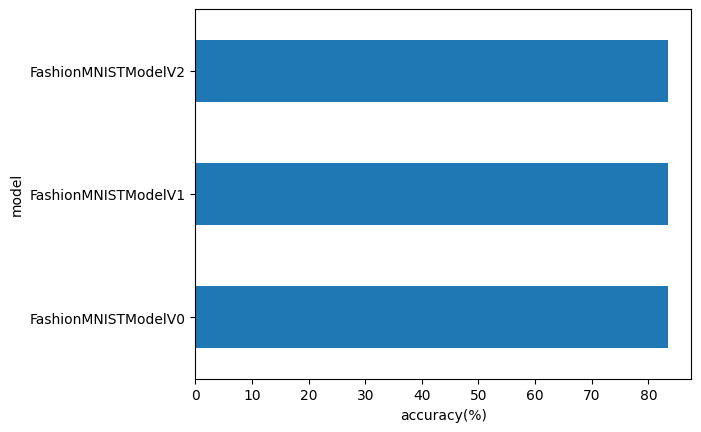

In [54]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy(%)")
plt.ylabel("model")

### 9. make and evaluate random predictions with best model



In [55]:
def make_predictions(model: torch.nn.Module,
                    data:list,
                    device:torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Forward pass
            pred_logit = model(sample)
            print(pred_logit.shape)
            # Get Prediction Probability (logits-> prediction probabilities -> prediction_labels)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim =0)
            print(pred_prob.shape)
            # Get Pred_prob off the GPU because matplot lib doesbot work on GPU
            pred_probs.append(pred_prob)
    # Stack the pred_probs to turn list into tensor
    return torch.stack(pred_probs)  #pred_probs


In [56]:
import random
random.seed(42)
test_samples = []
test_labels_dummy = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels_dummy.append(label)

# View the first sample shape
test_samples[0].shape


torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

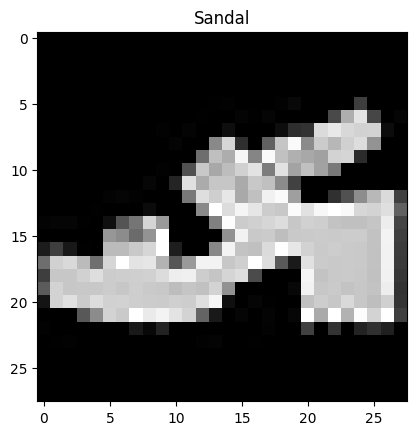

In [57]:
plt.imshow(test_samples[0].squeeze(), cmap = 'gray')
plt.title(class_names[test_labels_dummy[0]])


In [58]:
# Make predictions
pred_probs = make_predictions(model = model_2, data=test_samples)
pred_probs


torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([10])


tensor([[1.4140e-07, 2.2231e-09, 1.9989e-09, 2.3640e-10, 1.7174e-10, 9.9991e-01,
         1.4888e-07, 4.3946e-09, 1.8408e-06, 8.6735e-05],
        [6.8197e-02, 7.0723e-01, 9.9188e-04, 7.4493e-02, 1.2524e-02, 3.3156e-04,
         1.3274e-01, 4.7898e-04, 8.7727e-04, 2.1376e-03],
        [2.8425e-05, 2.4822e-07, 2.5507e-06, 7.7806e-07, 4.3913e-07, 5.0397e-04,
         5.6865e-06, 8.3601e-01, 4.0435e-04, 1.6305e-01],
        [1.5848e-03, 7.6388e-05, 6.7772e-01, 3.1452e-04, 3.1773e-01, 1.1934e-06,
         2.4409e-03, 3.0597e-07, 1.3137e-04, 5.7701e-06],
        [2.7726e-03, 1.9400e-06, 1.8228e-05, 9.8432e-01, 7.7740e-05, 8.4046e-06,
         1.2744e-02, 1.9748e-06, 2.6021e-05, 2.9349e-05],
        [4.1067e-01, 2.3983e-06, 1.2989e-04, 2.7030e-03, 3.7506e-04, 1.1232e-06,
         5.8581e-01, 1.4497e-07, 3.0304e-04, 2.5509e-07],
        [6.9506e-05, 7.2811e-06, 3.3974e-02, 1.9555e-06, 9.0685e-01, 2.0366e-06,
         5.8818e-02, 1.4606e-07, 2.5229e-04, 2.1172e-05],
        [4.8542e-06, 1.1750

In [59]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 6, 4, 7, 1])

In [60]:
test_labels_dummy

[5, 1, 7, 4, 3, 0, 4, 7, 1]

In [61]:
test_labels_dummy[0]

5

In [62]:
truth_label = class_names[test_labels_dummy[1]]
truth_label

'Trouser'

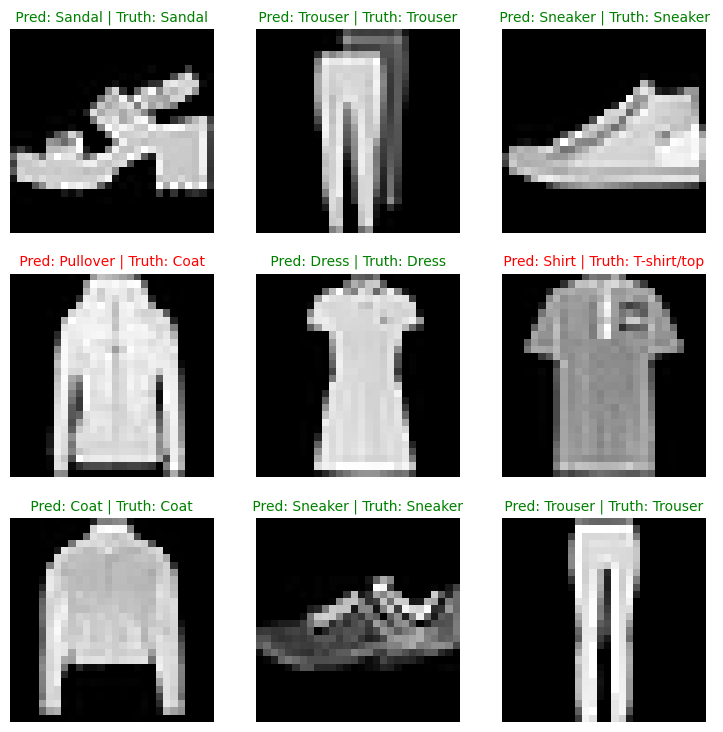

In [63]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols=3
for i,sample in enumerate(test_samples):
    # Create Subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap = "gray")

    # Find the predictions (in text form e.g."sandal")
    pred_label = class_names[pred_classes[i]]

    #   Get the truth label
    truth_label = class_names[test_labels_dummy[i]]

    # Create a title for the plot
    title_text = f" Pred: {pred_label} | Truth: {truth_label} "

    # Check for equality between pred and truth and change color of the title text

    if pred_label == truth_label:
        plt.title(title_text , fontsize = 10, c="g" ) # Green text if prediction same as truth
    else:
        plt.title(title_text, fontsize = 10, c = "r")

    plt.axis(False);

### 10. creating a confusion matrix for further prediction evaluation

1. make prediction with our trained model on the test dataset
2. make a confusion matrix "torchmetrics.ConfusionMatrix"
3. Plot the confusion matrix using 'mixtend.plotting.plot_confusion_matrix()'


In [87]:
# Make Prediction with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc = 'Making prediction...'):
        # send the data and targets to the target device
        X,y = X.to(device), y.to(device)
        # Forward pass
        y_logit = model_2(X)
        # Turn predictions from logits -> prediction probabilities -> prediction_labels
        y_label = torch.softmax(y_logit.squeeze(), dim=1).argmax(dim=1)
        y_preds.append(y_label)

y_pred_tensor = torch.cat(y_preds)

y_pred_tensor.shape

Making prediction...: 100%|██████████| 313/313 [00:01<00:00, 166.11it/s]


torch.Size([10000])

In [65]:
y_preds[0].shape


torch.Size([32, 10])

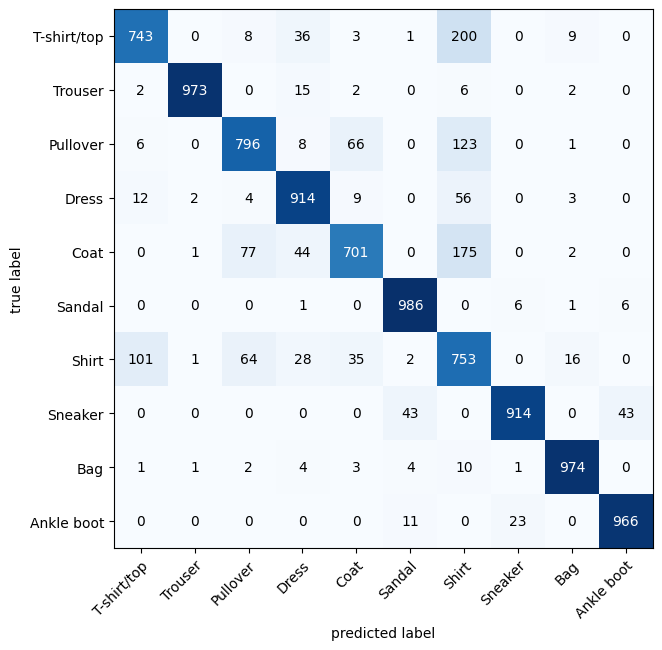

In [101]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Set up confusion instance and compare predictions to targets 
confmat = ConfusionMatrix(num_classes=len(class_names), task = "multiclass")
confmat_tensor = confmat(preds = y_pred_tensor,
                            target = test_data.targets)
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat= confmat_tensor.numpy(), # Matplot lib loves working with numpy
                                class_names=class_names,
                                figsize = (10,7))

### 11. Save and load best performing model

In [102]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok = True)

# Create model save
MODEL_NAME = "03_Pytorch_Computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model sate dict
print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
            f = MODEL_SAVE_PATH)


saving model to models/03_Pytorch_Computer_vision_model_2.pth


In [103]:
# Create a new instance
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10,output_shape= len(class_names))

# Load in the save state dict()
loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# send the model to the target device
loaded_model_2.to(device)

/tmp/ipykernel_3394123/4132608342.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [104]:
# Evaluate loaded model
torch.manual_seed(42)
loaded_model_2_results = eval_model(model= loaded_model_2, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
loaded_model_2_results


100%|██████████| 313/313 [00:01<00:00, 253.64it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

In [105]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.4772161841392517,
 'model_acc': 83.43650159744409}

In [106]:
# check if model results are close to each other 
torch.isclose(torch.tensor(model_2_results["model_loss"]),
                torch.tensor(loaded_model_2_results["model_loss"]),
                atol = 1e-02)

tensor(True)